In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
plt.style.use('ggplot') 
import calendar
import quandl
import pickle
import math
from datetime import datetime, timedelta
import re  
import psycopg2
import sys
import matplotlib.gridspec as gridspec
import sqlalchemy
from sqlalchemy.sql import select, and_, or_, not_, desc, asc
from sqlalchemy import Table, Column, Integer, DateTime, String,Float, ForeignKey
from sqlalchemy.orm import sessionmaker
from sklearn import preprocessing

In [2]:
# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 10
# fig_size[1] = 10
# plt.rcParams["figure.figsize"] = fig_size

In [3]:
def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    # We connect with the help of the PostgreSQL URL
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sqlalchemy.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sqlalchemy.MetaData(bind=con)

    return con, meta

CREATE TABLES 

In [4]:
con, meta = connect('postgres', '', 'robotdb')

mkt_trend = Table('Market_trend', meta,
                      Column('coin', String, primary_key=True),
                      Column('date', DateTime, primary_key=True),
                      Column('screen', Integer, primary_key=True),
                      Column('dif_current', Float),
                      Column('dif_base', Float),
                      Column('d_dif', Float),
                      Column('theta_current', Float),
                      Column('theta_base', Float),
                      Column('d_theta', Float),
                      Column('long_dif', Float),
                      Column('max_growth', Float),
                      Column('max_loss', Float),
                      Column('max_price', Float),
                      Column('min_price', Float),
                      Column('max_rel', Float),
                      Column('min_rel', Float),
                      Column('log_ret', Float),
                      Column('log_ret_p', Float),
                      Column('log_ret_t_1', Float),
                      Column('histogram', Float),
                      Column('ema_dif', Float),
                      Column('rsi', Float),
                      Column('dif_sma', Float),
                      Column('max_growth_p', Float),
                      Column('obv', Float),
                      Column('strength', Float),
                      Column('vote', Integer)
                      )

tickers = Table('Ticker', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('price', Float),
    Column('volume', Float),
    Column('screen', String, primary_key = True)    
)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

In [5]:
def get_mkt_trend(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.coin == coin, mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    else:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    rows = con.execute(s)
    mkt_trend_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    mkt_trend_df.columns = rows.keys()
    return mkt_trend_df

In [6]:
def scale_df(train, test, scale_columns):
    # #STANDARD SCALER
    scaler = preprocessing.StandardScaler().fit(train[scale_columns])
    train[scale_columns] = scaler.transform(train[scale_columns])
    test[scale_columns] = scaler.transform(test[scale_columns])
    return train, test

FETCH DATA FROM DATABASE AND JOIN TABLES 
MKTTREND - PRICE - MACDS - RSI - SMA

In [7]:
def manipulate_mkt_data():
    df_model = get_mkt_trend()
    df_model = df_model.drop(['max_growth_p'], axis=1).dropna()
    df_model.loc[df_model['max_growth'] >= 0.1, 'growth_sign'] = 1
    df_model.loc[df_model['max_growth'] < 0.1, 'growth_sign'] = 0
    dates_ = df_model[['date']]
    shifted_parms = df_model[['coin', 'max_growth']].shift(6)
    shifted_parms['date'] = dates_
    df_model = pd.merge(df_model, shifted_parms, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    df_model['max_growth'] = df_model['max_growth_x']
    df_model['max_growth_p'] = df_model['max_growth_y']
    df_model = df_model.drop(['max_growth_x', 'max_growth_y'], axis=1)
    df = df_model.drop(['screen', 'coin'] ,axis=1)
    return df
    

df_model = manipulate_mkt_data()
df_model.columns
df_model['strength_ema'] = df_model.strength.ewm(span=6,min_periods=6,adjust=True,ignore_na=False).mean()
df_model = df_model.dropna()
df_model = df_model.sort_values(['date']).reset_index().drop(['index'], axis=1)

In [8]:
df = df_model.drop(['date', 'max_price', 'min_price', 'vote', 'max_growth', 'max_loss'], axis=1)
df.head()

dif_current   dif_base     d_dif  theta_current  theta_base   d_theta  \
0    44.356392  41.976364  0.056699      -1.200480   -1.169756  0.026265   
1    41.976364  45.026093 -0.067732      -1.202489   -1.173444  0.024752   
2    45.026093  49.707213 -0.094174      -1.203341   -1.175292  0.023865   
3    49.707213  49.289268  0.008479      -1.203929   -1.177050  0.022835   
4    49.289268  49.397713 -0.002195      -1.203719   -1.177316  0.022426   

     long_dif   max_rel   min_rel   log_ret      ...       log_ret_t_1  \
0  106.872960  0.010147 -0.049590  0.001188      ...          0.000910   
1  108.153565  0.005513 -0.031624  0.020409      ...          0.001188   
2  108.153565  0.004569 -0.055201  0.014046      ...          0.020409   
3  108.153565  0.017854 -0.041916 -0.009394      ...          0.014046   
4  108.153565  0.002805 -0.056966  0.012489      ...         -0.009394   

   histogram   ema_dif       rsi    dif_sma           obv      strength  \
0  -0.128376  0.005638  0.468498  69.131713  2.546783e+07  1.156830e+07   
1   2.476249  0.013282  0.489548  75.301260  2.839216e+07  1.393641e+08   
2   6.297034  0.029860  0.457974  78.215907  3.365137e+07  1.754958e+08   
3   4.385611  0.013208  0.472067  83.065907  3.052121e+07 -7.001937e+07   
4   3.319876  0.023518  0.470902  90.145405  3.425447e+07  1.111914e+08   

   growth_sign  max_growth_p  strength_ema  
0          0.0      0.036143  1.887977e+07  
1          0.0      0.025854  5.691174e+07  
2          0.0      0.049211  9.325557e+07  
3          0.0      0.034486  4.423288e+07  
4          0.0      0.045140  6.404897e+07  

[5 rows x 21 columns]

Unbalanced Dataset 0.08020190689848569


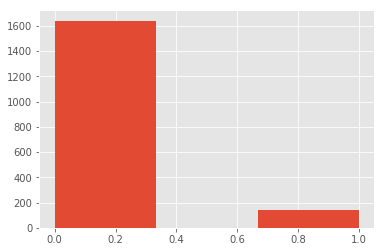

In [9]:
plt.hist(df['growth_sign'], bins=3)
print('Unbalanced Dataset %s' % str(np.sum(df['growth_sign'])/len(df_model)))
plt.show()

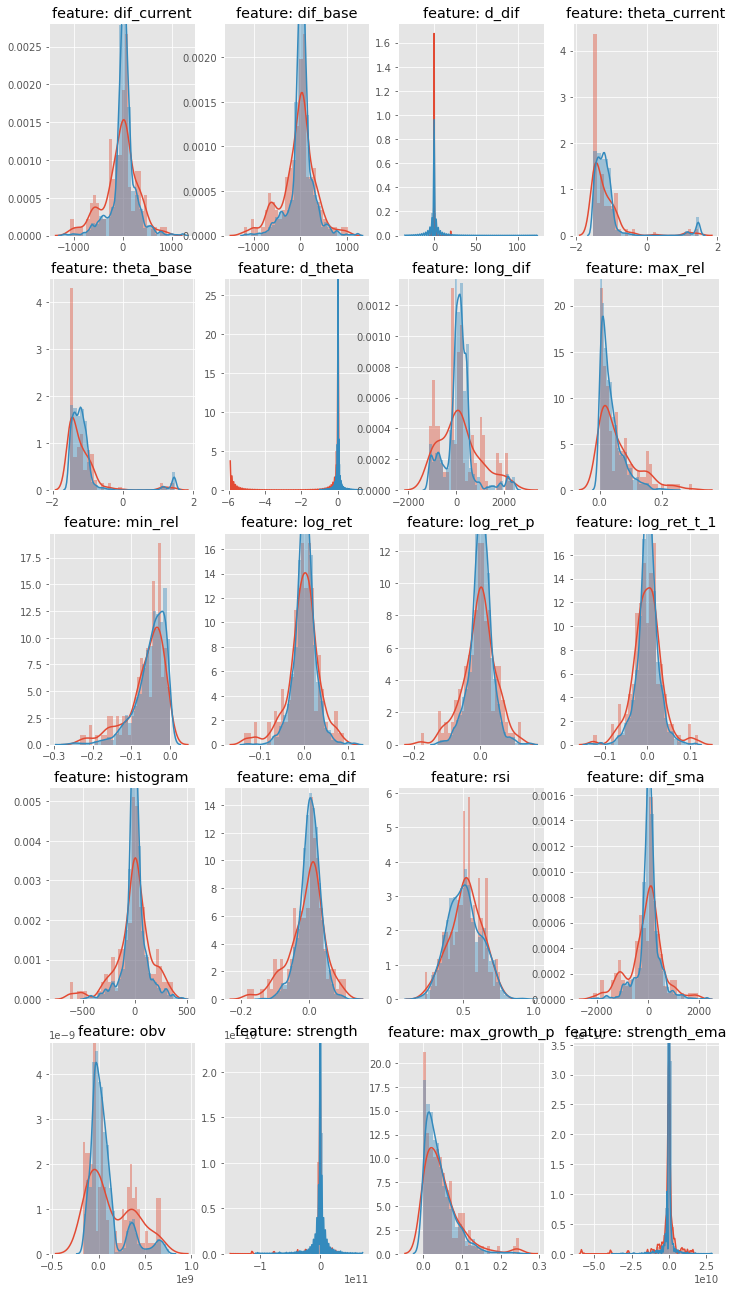

In [10]:
plt.figure(figsize=(12,8*4))
gs = gridspec.GridSpec(7, 4)
for i, cn in enumerate(df.drop(['growth_sign'], axis=1).columns):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.growth_sign == 1], bins=30)
    sns.distplot(df[cn][df.growth_sign == 0], bins=30)
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))
plt.show()

In [11]:
train = df.iloc[0:math.floor(len(df)*0.75)].copy()
test = df.iloc[math.floor(len(df)*0.75):len(df)].copy()

In [ ]:
# scale_columns = df.drop(['growth_sign'], axis=1)
# scaler = preprocessing.StandardScaler().fit(train[scale_columns])
# train[scale_columns] = scaler.transform(train[scale_columns])
# test[scale_columns] = scaler.transform(test[scale_columns])

In [ ]:
# # #EXAMPLE FOR SCALE NEW ENTRY
# t_transform = scaler.transform(df.loc[0,scale_columns].values.reshape(1,-1))
# print(t_transform)

In [12]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

In [13]:
print('---------------------------------------------------')
X_train, y_train = train.drop(['growth_sign'], axis=1), train.growth_sign.values
X_test, y_test =  test.drop(['growth_sign'], axis=1), test.growth_sign.values
oversampler = SMOTE(random_state=42)
X_train_os, Y_train_os = oversampler.fit_sample(X_train,y_train)

# RANDOM FOREST
print('Random Forest')
param_grid = {'max_depth': np.arange(1, 20), 'min_samples_leaf':np.arange(1, 8),}
model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='precision')
model.fit(X_train_os, Y_train_os)
Y_predict = model.predict(X_test)

print(model.best_params_)
cm = confusion_matrix(y_test,Y_predict)
print('Precision: %s' % float(cm[1][1]/(cm[1][1]+cm[0][1])))
print(cm)
print('---------------------------------------------------')

# EXTRATREE
print('Extra Tree')
X_train, y_train = train.drop(['growth_sign'], axis=1), train.growth_sign.values
X_test, y_test =  test.drop(['growth_sign'], axis=1), test.growth_sign.values
oversampler = SMOTE(random_state=42)
X_train_os, Y_train_os = oversampler.fit_sample(X_train,y_train)

model = ExtraTreesClassifier()
model.fit(X_train_os,Y_train_os)
Y_predict = model.predict(X_test)
print(model.feature_importances_)
cm = confusion_matrix(y_test,Y_predict)
print('Precision: %s' % float(cm[1][1]/(cm[1][1]+cm[0][1])))
print(cm)
print('---------------------------------------------------')

---------------------------------------------------
Random Forest
{'max_depth': 14, 'min_samples_leaf': 2}
Precision: 0.09045226130653267
[[233 181]
 [ 14  18]]
---------------------------------------------------
Extra Tree
[ 0.04396884  0.0390002   0.02720059  0.07515012  0.08420826  0.0463461
  0.07085067  0.05287337  0.04027866  0.03432945  0.03625447  0.02666136
  0.04280938  0.04153766  0.07472576  0.04844554  0.08986908  0.03858351
  0.04315665  0.04375033]
Precision: 0.10559006211180125
[[270 144]
 [ 15  17]]
---------------------------------------------------


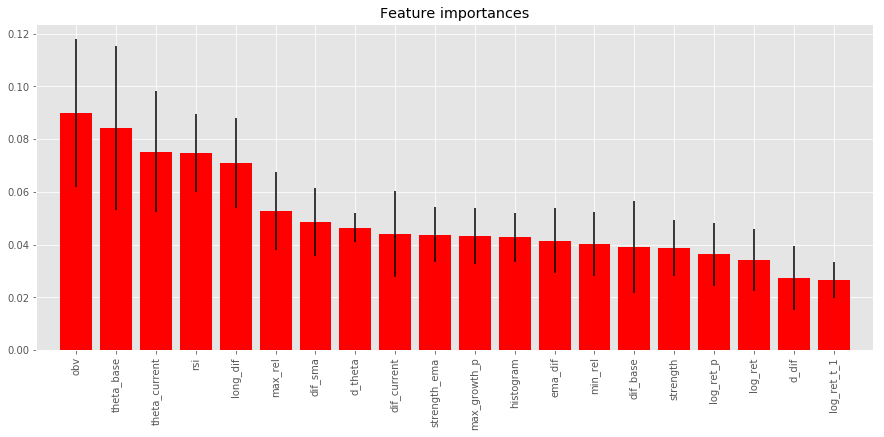

In [14]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_names = [X_train.columns[i] for i in indices]

plt.figure(figsize=(15,6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names)
plt.xlim([-1, X_train.shape[1]])
plt.xticks(rotation=90)
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline

print('---------------------------------------------------')
X_train, y_train = train.drop(['growth_sign'], axis=1), train.growth_sign.values
X_test, y_test =  test.drop(['growth_sign'], axis=1), test.growth_sign.values
oversampler = SMOTE(random_state=42)
X_train_os, Y_train_os = oversampler.fit_sample(X_train,y_train)

# RANDOM FOREST
print('Random Forest')
param_grid = {'max_depth': np.arange(1, 20), 'min_samples_leaf':np.arange(1, 8),}


estimator = RandomForestClassifier(random_state=42)
selector = RFECV(estimator, step=1, cv=4, scoring='precision')
selector.fit(X_train_os, Y_train_os)
print("Optimal number of features : %d" % selector.n_features_)

In [ ]:
X_train_f = selector.transform(X_train_os)
X_test_f = selector.transform(X_test)
model = GridSearchCV(estimator, param_grid, cv=5, scoring='precision')
model.fit(X_train_f, Y_train_os)
Y_predict = model.predict(X_test_f)

print(model.best_params_)
cm = confusion_matrix(y_test,Y_predict)
print('Precision: %s' % float(cm[1][1]/(cm[1][1]+cm[0][1])))
print(cm)
print('---------------------------------------------------')